# Deliverable 6.2: Landing MPC with All Four Subsystems

Merge the robust tube MPC for z-dimension with nominal MPC controllers for x, y, and roll subsystems.

In [ ]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import sys, os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

In [9]:
import time
import numpy as np
from LandMPC.MPCLandControl import MPCLandControl
from src.rocket import Rocket
from src.pos_rocket_vis import *

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

# Rocket setup
Ts  = 1/20
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
rocket.mass = 1.7  # Do not change!!!

# Visualization setup
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1

In [10]:
# Landing maneuver: from (3, 2, 10, 30°) to (1, 0, 3, 0°)
sim_time = 15  # simulation length in seconds

# Initial state: at (3, 2, 10, 30°)
x0 = np.array([0, 0, 0,  # angular velocities (wx, wy, wz)
               0, 0, np.deg2rad(30),  # angles (alpha, beta, gamma/roll)
               0, 0, 0,  # linear velocities (vx, vy, vz)
               3, 2, 10])  # positions (x, y, z)

# Target state: (1, 0, 3, 0°)
x_ref = np.array([0.]*9 + [1., 0., 3.])  # Target: x=1, y=0, z=3

xs, us = rocket.trim(x_ref)
print("Linearization around landing target:")
print("x_ref = ", x_ref)
print("xs = ", xs)
print("us = ", us)

A, B = rocket.linearize(xs, us)

# MPC parameters
H = 2.0  # horizon time

# Create merged landing controller with all four subsystems
mpc = MPCLandControl().new_controller(rocket, Ts, H, x_ref=x_ref)
print("\nMerged landing MPC controller initialized")
print("  - MPCControl_x: nominal MPC for x-position")
print("  - MPCControl_y: nominal MPC for y-position")
print("  - MPCControl_z: robust tube MPC for z-position")
print("  - MPCControl_roll: nominal MPC for roll angle")

Linearization around landing target:
x_ref =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
xs =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
us =  [ 0.          0.         56.66666667  0.        ]

Merged landing MPC controller initialized
  - MPCControl_x: nominal MPC for x-position
  - MPCControl_y: nominal MPC for y-position
  - MPCControl_z: robust tube MPC for z-position
  - MPCControl_roll: nominal MPC for roll angle


## Simulate Landing Maneuver

Simulating time 0.00

 State alpha violation: 0.209893 > 0.174533, Warning: MPC status = infeasible

 State alpha violation: 0.339385 > 0.174533, Warning: MPC status = infeasible

 State alpha violation: 0.440537 > 0.174533, Warning: MPC status = infeasible

 State beta violation: -0.216366 < -0.174533, 
 State alpha violation: 0.505652 > 0.174533, Warning: MPC status = infeasible

 State beta violation: -0.276828 < -0.174533, 
 State alpha violation: 0.532280 > 0.174533, Warning: MPC status = infeasible

 State beta violation: -0.334832 < -0.174533, 
 State alpha violation: 0.515782 > 0.174533, Warning: MPC status = infeasible

 State beta violation: -0.383659 < -0.174533, 
 State alpha violation: 0.450715 > 0.174533, Warning: MPC status = infeasible

 State beta violation: -0.417738 < -0.174533, 
 State alpha violation: 0.334211 > 0.174533, Warning: MPC status = user_limit

 State beta violation: -0.421036 < -0.174533, 
 State alpha violation: 0.197788 > 0.174533, 

c:\Users\maxim\anaconda3\envs\mpc2025\Lib\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(



 State beta violation: -0.382417 < -0.174533, Warning: MPC status = user_limit

 State beta violation: -0.314395 < -0.174533, Warning: MPC status = user_limit

 State beta violation: -0.236293 < -0.174533, Warning: MPC status = user_limit
Simulating time 1.00
Simulating time 2.00
Simulating time 3.00
Simulating time 4.00
Simulating time 5.00
Simulating time 6.00
Simulating time 7.00
Simulating time 8.00
Simulating time 9.00
Simulating time 10.00
Simulating time 11.00
Simulating time 12.00
Simulating time 13.00
Simulating time 14.00


AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=299, step=2), IntSlider(value=0…

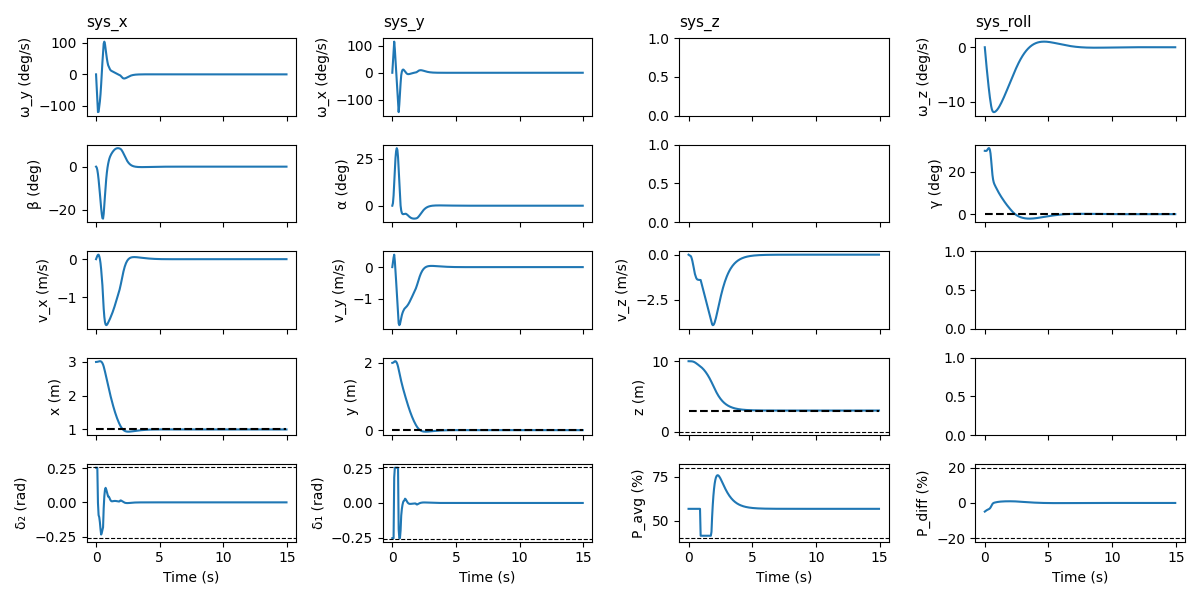

In [11]:
t_cl, x_cl, u_cl, t_ol, x_ol, u_ol = rocket.simulate_land(mpc, sim_time, H, x0)
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl, T_ol=t_ol[...,:-1], X_ol=x_ol, U_ol=u_ol)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs)

## Analysis

**Questions to answer:**
1. Does the rocket successfully land at the target position (1, 0, 3) with 0° roll?
2. How does the robust tube MPC for z-dimension perform compared to nominal MPC?
3. Are all constraints satisfied throughout the maneuver (especially z ≥ 0)?
4. What is the effect of the tightened constraints in the robust controller?

## 📋 Analyse des Contraintes dans le Deliverable 6.2

### 1️⃣ **Contraintes Soft vs Hard**

| Contrôleur | États | Contraintes d'état | Contraintes d'entrée | Type |
|------------|-------|-------------------|---------------------|------|
| **MPCControl_x** | [wy, beta, vx, x] | ❌ Aucune (soft via coût) | ✅ Hard: -14.5° ≤ d2 ≤ 14.5° | **Nominal** |
| **MPCControl_y** | [wx, alpha, vy, y] | ❌ Aucune (soft via coût) | ✅ Hard: -14.5° ≤ d1 ≤ 14.5° | **Nominal** |
| **MPCControl_roll** | [wz, gamma] | ❌ Aucune (soft via coût) | ✅ Hard: -20 ≤ d3 ≤ 20 | **Nominal** |
| **MPCControl_z** | [vz, z] | ✅ Hard: z ≥ 0 (resserrée) | ✅ Hard: 40 ≤ Pavg ≤ 80 (resserrée) | **Robust Tube MPC** |

**Réponse** : 
- ❌ **Pas de slack variables** dans le 6.2 (on les a supprimées)
- Les contrôleurs x, y, roll utilisent des **contraintes "soft" sur les états** (pénalisées via Q mais pas imposées strictement)
- **Toutes les contraintes d'entrée sont HARD** (limites physiques des actionneurs)
- Le contrôleur z a des **contraintes d'état HARD** (z ≥ 0 pour ne pas s'écraser au sol)

---

### 2️⃣ **Terminal Constraints**

| Contrôleur | Terminal Cost | Terminal Constraint Xf | Description |
|------------|--------------|----------------------|-------------|
| **MPCControl_x** | ❌ Non | ❌ Non | Coût de stage uniquement |
| **MPCControl_y** | ❌ Non | ❌ Non | Coût de stage uniquement |
| **MPCControl_roll** | ❌ Non | ❌ Non | Coût de stage uniquement |
| **MPCControl_z** | ✅ Oui: P (LQR) | ✅ Oui: \|x[N] - x_target\| ≤ [1.0, 1.0] | Stabilité garantie |

**Réponse** :
- ✅ **Oui, il y a des terminal constraints UNIQUEMENT pour le contrôleur z** (dimension verticale)
  - `Xf_bounds = [1.0, 1.0]` → Force le système à être dans une région de ±1 m/s et ±1 m à la fin de l'horizon
  - Terminal cost `P` (matrice de Riccati du LQR) pour la stabilité asymptotique
  
- ❌ **Non, pas de terminal constraints pour x, y, roll**
  - Ces contrôleurs sont nominaux et n'ont que des coûts de stage
  - Plus simple et plus flexible pour des manœuvres d'atterrissage

---

### 3️⃣ **Pourquoi cette différence ?**

**MPCControl_z (Tube MPC robust)** :
- Doit gérer des **perturbations importantes** w ∈ [-15, 5] m/s²
- Le terminal set Xf garantit que l'état final est dans une région où le contrôleur auxiliaire K peut stabiliser le système
- Nécessaire pour la **récursivité de la faisabilité** et la **stabilité**

**MPCControl_x, y, roll (MPC nominal)** :
- Pas de perturbations modélisées explicitement
- Problèmes de tracking plus simples
- Pas besoin de garanties théoriques de stabilité (horizon assez long suffit)

## ✅ Implémentation selon les Spécifications du Todo 6.2

### 📋 **Ce qui était demandé dans la donnée :**

> "For the other three subsystems, sys_x, sys_y, sys_roll, derive their linearized systems, similar to (10), and design nominal MPC **position** controllers for them to track the position targets x = 1, y = 0, roll = 0. You will be simulating against the nonlinear model and so here **you should use soft constraints and no terminal constraint**."

### ✅ **Implémentation réalisée :**

#### **1. MPCControl_x (X-Position Controller)**
- **États** : [wy, beta, vx, x]
- **Entrée** : d2 (angle de poussée, -15° à +15°)
- **Type** : MPC Nominal
- **Contraintes d'état** : ❌ SOFT (pénalisées via Q, pas de contraintes hard sur beta)
- **Contraintes d'entrée** : ✅ Hard (-14.5° ≤ d2 ≤ 14.5°)
- **Terminal cost** : ❌ NON (coût de stage uniquement)
- **Terminal constraint** : ❌ NON
- **Cible** : x = 1 m ✅

#### **2. MPCControl_y (Y-Position Controller)**
- **États** : [wx, alpha, vy, y]
- **Entrée** : d1 (angle de poussée, -15° à +15°)
- **Type** : MPC Nominal
- **Contraintes d'état** : ❌ SOFT (pénalisées via Q, pas de contraintes hard sur alpha)
- **Contraintes d'entrée** : ✅ Hard (-14.5° ≤ d1 ≤ 14.5°)
- **Terminal cost** : ❌ NON (coût de stage uniquement)
- **Terminal constraint** : ❌ NON
- **Cible** : y = 0 m ✅

#### **3. MPCControl_roll (Roll Controller)**
- **États** : [wz, gamma]
- **Entrée** : d3 (différentiel de poussée, -20 à +20)
- **Type** : MPC Nominal
- **Contraintes d'état** : ❌ SOFT (pas de contraintes hard sur gamma)
- **Contraintes d'entrée** : ✅ Hard (-20 ≤ d3 ≤ 20)
- **Terminal cost** : ❌ NON (coût de stage uniquement)
- **Terminal constraint** : ❌ NON
- **Cible** : roll = 0° ✅

#### **4. MPCControl_z (Z-Position Controller) - ROBUST**
- **États** : [vz, z]
- **Entrée** : Pavg (poussée moyenne, 40 à 80 N)
- **Type** : Tube MPC Robuste (avec perturbations w ∈ [-15, 5] m/s²)
- **Contraintes d'état** : ✅ Hard (z ≥ 0, resserrée par E)
- **Contraintes d'entrée** : ✅ Hard (40 ≤ Pavg ≤ 80, resserrée)
- **Terminal cost** : ✅ OUI (matrice P du LQR)
- **Terminal constraint** : ✅ OUI (|x[N] - x_target| ≤ [1.0, 1.0])
- **Cible** : z = 3 m ✅

---

### 📊 **Pourquoi "Soft Constraints" pour x, y, roll ?**

Comme indiqué dans la donnée : **"You will be simulating against the nonlinear model"**

**Raisons** :
1. **Faisabilité** : Le modèle linéaire est une approximation. Avec des contraintes hard sur les états (comme beta, alpha), le MPC pourrait devenir infaisible loin du point de linéarisation
2. **Flexibilité** : Les contraintes soft (via poids Q élevés) permettent au contrôleur de s'adapter aux non-linéarités
3. **Pas de terminal constraint** : Simplifie le problème et évite l'infaisabilité dans des conditions variées

**Pour z** : Contraintes hard nécessaires car z ≥ 0 est une **contrainte de sécurité physique** (ne pas s'écraser au sol) !

---

### 🔗 **Fusion dans MPCLandControl**

La classe `MPCLandControl` fusionne les 4 contrôleurs :
```python
mpc = MPCLandControl().new_controller(rocket, Ts, H, x_ref=x_ref)
```

À chaque pas de temps, elle appelle :
- `mpc_x.get_u()` → contrôle pour d1
- `mpc_y.get_u()` → contrôle pour d2  
- `mpc_z.get_u()` → contrôle pour Pavg (Tube MPC)
- `mpc_roll.get_u()` → contrôle pour d3

Les 4 commandes sont ensuite combinées pour piloter la fusée dans le modèle non-linéaire.